# Deep Convolutional Generative Adversarial Network

In this notebook we will try to apply GAN principle on MNIST fashion dataset <br> 1.) In GAN two models are trained simultaniously 
<br>     a.) Generator :- It's job is to generate meaningful data out of random noise
<br>     b.) Discriminator:- It's job is to discriminate fake outputs generated from the generator from the training data

<br> Over time both models are rivals each other i.e generator tries to fool the discriminator and desriminator tries not to get fooled.
<br> The training process happens till the generator is good enough to generate real like output and the descriminator fails to discriminate real from fake.

## GAN vs DCGAN
GAN(Generative Adversarial Network) - It uses vanila neural networks i.e dense layers to cunstruct Generator and Descriminator.
<br> DCGAN(Deep Convolutional Generative Adversarial Network) - It uses Convolution neural network to cunstruct Generator and Descriminator.

<img src="https://gluon.mxnet.io/_images/dcgan.png"/>

  

In [1]:
# Importing neccessary libraries
import tensorflow as tf
from tensorflow.keras.datasets import mnist,fashion_mnist

import time
import glob 
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.train import Checkpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization,Conv2D,Conv2DTranspose,LeakyReLU,ReLU,Reshape,Dropout,Flatten,Dense
from IPython import display

In [2]:
# Normalizer diviser
norm_divisor = 127.5

In [3]:
# Creating a generate and save images which we will use later in 
def generate_and_save_img(model,epoch,test_ip):
  y_pred = model(test_ip,training=False)
  fig = plt.figure(figsize=(4,4))

  for i in range(y_pred.shape[0]):
    plt.subplot(4,4,i+1)
    # multiply and add with norm divisor will bring the pixel intensity back to the initial scale
    plt.imshow(y_pred[i,:,:,0]*norm_divisor+norm_divisor,cmap='gray')
    plt.axis("off")

  plt.savefig("img_at_epoch{:d}.png".format(epoch))
  plt.show()

###Data Prepration

In [4]:
# Loading data
(X_train_img,y_train_label),(_,_) = fashion_mnist.load_data()
# Reshaping the data accordingly
X_train_img =  X_train_img.reshape(X_train_img.shape[0],X_train_img.shape[1],X_train_img.shape[2],1)
# As we know that max value of pixel intencity is 255 but we want to bring the scaling b/w -1 to 1 
# So we divide by 127.5
X_train_img = (X_train_img-norm_divisor)/norm_divisor

4423680/4422102 [==============================] - 0s 0us/step


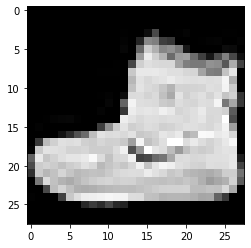

In [5]:
plt.imshow(X_train_img[0,:,:,0],cmap='gray')

In [6]:
buffer_size = X_train_img.shape[0]
batch_size = 256

In [7]:
# Batch and shuffle the data 
X_train_img = tf.data.Dataset.from_tensor_slices(X_train_img).shuffle(buffer_size).batch(batch_size)

## Model Creation 

In [8]:
### Create Generator 
def get_generator():
  n_dim = 7
  model = Sequential()
  model.add(Dense(n_dim*n_dim*batch_size,use_bias=False,input_shape=(100,)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Reshape((n_dim,n_dim,batch_size)))
  # Here Conv2DTranspose is used to upsample the desne data into a 2D matrix space so that is projects like an image
  model.add(Conv2DTranspose(128,kernel_size=(5,5),strides=(1,1),padding='same',use_bias=False))
  # model output shape should be 7*7*128
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(64,kernel_size=(5,5),strides=(2,2),padding='same',use_bias=False))
  # model output shape should be 14*14*64
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(1,kernel_size=(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))
  # output shape should be 28*28*1
  return model

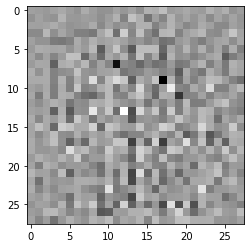

In [9]:
# Let's Examin a random image generated by the generator 
# As this is an untrained network so you can se a compleately random image
generator = get_generator()
noise = tf.random.normal([1,100])
generated_img  = generator(noise,training=False)
plt.imshow(generated_img[0,:,:,0],cmap='gray')

In [10]:
# Getting the Descriminator 
def get_descriminator():
  model = Sequential()
  model.add(Conv2D(64,kernel_size=(5,5),strides=(2,2),padding='same',input_shape=(28,28,1)))
  model.add(LeakyReLU())
  model.add(Dropout(0.2))

  model.add(Conv2D(128,kernel_size=(5,5),strides=(2,2),padding='same'))
  model.add(LeakyReLU())
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(1))
  return model

In [11]:
# Trying to classify randomly generated image with untrained descriminator
descriminator = get_descriminator()
print(descriminator(generated_img))

tf.Tensor([[-0.00215101]], shape=(1, 1), dtype=float32)


In [12]:
# Defining cross entropy loss however we will experiment with other loss functions too
binary_crossentropy = BinaryCrossentropy(from_logits=True)

#### Defining descriminator loss
<br>1.)The goal of descriminator loss is to enable us in terms of judgeing, how the descriminator is able to distinguish real images from fake .
<br>2.)It compares the descriminator's prediction on real image as 1 .
<br>3.)It compares the descriminator's prediction on fake image's as 0.

In [13]:
# Get generator 
def get_descrimination_loss(y_actual,y_generated):
  act_loss = binary_crossentropy(y_true=tf.ones_like(y_actual),y_pred=y_actual)
  generated_loss = binary_crossentropy(y_true=tf.zeros_like(y_generated),y_pred=y_generated)
  return act_loss + generated_loss

#### Defining generator loss
<br>1.) The generator loss quantifies how efficiently it is goin to trick the descriminator.
<br>2.) It generator is efficient enough than the descriminator will classify fake image as 1.

In [14]:
def get_generator_loss(y_generated):
  return binary_crossentropy(tf.ones_like(y_generated),y_generated)

In [15]:
# Let's consider ADAM as optimizer 
generator_optimizer = Adam(learning_rate=1e-4)
descriminator_optimizer = Adam(learning_rate=1e-4)

In [16]:
# Creating a checkpoint 
checkpoint_dir = "./chkpt/train_chkpoints"
checkpoint = Checkpoint(generator_optimizer=generator_optimizer,
                        descriminator_optimizer = descriminator_optimizer,
                        generator = generator,
                        descriminator = descriminator)

### Defining training functions
<br> 1.) Training begins with generator receiving a random seed with which it will produce an image.
<br> 2.) By generated image which is ingested by descriminator.
<br> 3.) The descriminator than classifies the generated image with actual image from the training set.

In [17]:
epocs = 100
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate,noise_dim])

In [18]:
# Defining training step
# here tf.function will enable the function to pre compile and let us use it later as a lazy evaluation
@tf.function
def a_train_step(images):
  noise = tf.random.normal((batch_size,noise_dim))

  with tf.GradientTape() as g_tape,tf.GradientTape() as d_tape:
    generated_imgs = generator(noise,training=True)
    # Getting prediction on actual images
    y_act = descriminator(images,training=True)
    # Getting prediction on fake images
    y_fake = descriminator(generated_imgs,training=True)
    # Getting generator loss
    g_loss = get_generator_loss(y_fake)
    # Getting actual vs fake loss
    d_loss = get_descrimination_loss(y_act,y_fake)
    generator_gradient = g_tape.gradient(g_loss,generator.trainable_variables)
    descriminator_gradient = d_tape.gradient(d_loss,descriminator.trainable_variables)
    # Applying gradient received across all layers of Neural netwok
    generator_optimizer.apply_gradients(zip(generator_gradient,generator.trainable_variables))
    descriminator_optimizer.apply_gradients(zip(descriminator_gradient,descriminator.trainable_variables))

In [19]:
def train(dataset,epocs):
  for epoc in range(epocs):
    s = time.time()
    for img_batch in dataset:
      a_train_step(img_batch)

      # Save model every 20 epocs
      if((epoc+1)%20 == 0):
        checkpoint.save(file_prefix=checkpoint_dir)

    print("Time taken for epoch {} is {}".format(epoc+1,time.time()-s))
    # for producing GIF 
    display.clear_output(wait=True)
    generate_and_save_img(generator,epoc+1,seed)

         

### Training the model

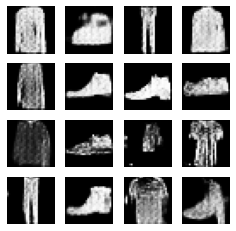

In [20]:
train(X_train_img,epocs)

###Sample prediction

As you can see below our DCGAN is able to generate shoe image out of some random input.
This is what generrator models do, they generate relevent data by being fed some random numbers.

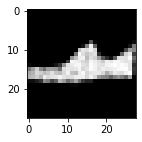

In [35]:
# Generate an number
noise = tf.random.normal([1,100])
pred_num = (generator(noise)*norm_divisor)+norm_divisor
plt.figure(figsize=(2,2))
plt.imshow(pred_num[0,:,:,0],cmap='gray')